In [3]:
import pyxdf
import mne
import scipy
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing (No artifact removal via EOG)

In [4]:
# -- |Data details| --
participant_id = '00'
n_session = 4

# -- |Local parameters|--
epochs_list = [] 

for i in range(1,n_session+1):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P0{participant_id}/ses-S00{str(i)}/eeg/sub-P0{participant_id}_ses-S00{str(i)}_task-Default_run-001_eeg.xdf") #Example Data from Lab Recoder
    
    # -- |EEG data| --
    EEG = [data for data in streams if data['info']['type'] == ['EEG']][0] #From Steam variable this query is EEG data
    raw_data = (EEG["time_series"].T)/1000000 # Convert to volt
    raw_data.shape # It contain with 8 channel of EGG data

    # -- |Channels Information| --
    channels = ['Fz','C3','Cz','C4','Pz','PO7','PO8','EOG'] #Set your target EEG channel name
    info = mne.create_info(
        ch_names= channels,
        ch_types= ['eeg']*(len(channels) - 1) + ['eog'],
        sfreq= 250  #OpenBCI Frequency acquistion
    )

    # -- |Create MNE rawarray| --
    raw_mne = mne.io.RawArray(raw_data, info, verbose=False)

    # -- |Common Average Reference| --
    mne_car = raw_mne.copy().set_eeg_reference('average')

    # -- |Bandpass filter| --
    mne_alpha = mne_car.filter(l_freq=8.0, h_freq=13.0, fir_design='firwin', verbose=False)

    # -- |Events|--
    Events = [data for data in streams if data['info']['type'] == ['Markers']][0]

    event_index = Events["time_series"].T[0] #Get all event marker of experiment 
    event_timestamp = (((Events["time_stamps"].T) - EEG["time_stamps"][0]) *250).astype('int')

    events = np.column_stack((np.array(event_timestamp, dtype = int),
                        np.zeros(len(event_timestamp), dtype = int),
                        np.array(event_index, dtype = int)))

    events_id = { # Set up your event name
        'right': 0,
        'left': 1
    }

    # -- |Epoch Segmentation| --
    epochs = mne.Epochs(mne_alpha, events, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 3.0,      # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id,
        preload = True,
        verbose=True,
        picks = ['eeg']
    )

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
31 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 876 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
31 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 876 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
31 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items a

Number of events,123
Events,left: 60right: 63
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


    Using multitaper spectrum estimation with 7 DPSS windows


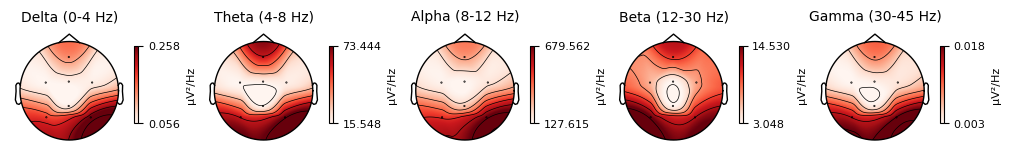

In [5]:
epochs['right'].compute_psd().plot_topomap();

    Using multitaper spectrum estimation with 7 DPSS windows


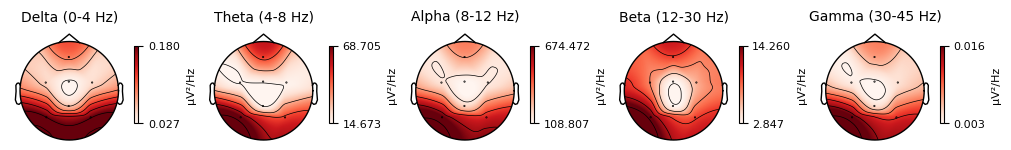

In [6]:
epochs['left'].compute_psd().plot_topomap();

In [7]:
# Get EEG data and events
X = epochs.get_data(copy=False)
Y = epochs.events[:, -1]

print(f'EEG data shape: {X.shape}')
print(f'events shape  : {Y.shape}')

EEG data shape: (123, 7, 876)
events shape  : (123,)


In [31]:
X

array([[[-3.94197903e-08, -2.47119917e-08,  7.86963047e-09, ...,
          6.70318157e-07,  8.06376100e-07,  8.51184202e-07],
        [ 1.71838266e-06,  1.66639126e-06,  1.51830431e-06, ...,
         -9.00304920e-07, -9.85999199e-07, -1.04629816e-06],
        [ 1.12819031e-06,  1.18652515e-06,  1.16674579e-06, ...,
          1.56267410e-07,  1.70648239e-07,  1.79210648e-07],
        ...,
        [-3.43101945e-07, -3.09497091e-07, -2.51206416e-07, ...,
         -3.92482250e-07, -2.36766058e-07, -5.13920818e-08],
        [-4.90263989e-08, -4.23507331e-07, -7.55024695e-07, ...,
         -4.11377902e-07, -1.14421271e-06, -1.78068198e-06],
        [-2.32191589e-06, -2.20247456e-06, -1.93211183e-06, ...,
          5.74926161e-07,  8.54521988e-07,  1.08380834e-06]],

       [[-6.27993573e-07, -9.70772413e-07, -1.27337591e-06, ...,
         -3.75825157e-06, -3.80711577e-06, -3.64242062e-06],
        [ 3.62285569e-07,  1.78972337e-07, -5.22494762e-08, ...,
         -1.24772054e-06, -1.31534851e

In [28]:
from mne.decoding import CSP

ureka = []

for i in range(1000):
    try:
        # Initilize CSP
        csp = CSP(n_components = i, norm_trace = False)

        # Fit CSP to data 
        csp.fit(X, Y)

        # # Visualize CSP patterns
        # csp.plot_patterns(epochs.info);
    
        ureka.append(i)
    except:
        pass

print(ureka)

Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 7 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 7 dim * 1e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 7 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 7 dim * 1e+09  max singular value)
    Estimated rank (mag

In [30]:
# Initilize CSP
csp = CSP(n_components = 4, norm_trace = False)

# Fit CSP to data 
csp.fit(X, Y)

# # Visualize CSP patterns
# csp.plot_patterns(epochs.info);

Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 7 dim * 1.1e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 7 dim * 1e+09  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.


LinAlgError: The leading minor of order 7 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.